## Imports

In [40]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle
import os
from sklearn.model_selection import train_test_split

# LINEAR REG
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

# Over-sampling for imbalance problem
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

## Pre-process data

In [49]:
os.chdir('/Users/hadi/Documents/Professional_development/DS/INSIGHT/Project/Data/Data_pro')
raw_data=pd.read_csv('Data_All_sorted_alpha_MVP_V6.csv')

#raw_data.index = raw_data.Neighbourhood

Y = pd.DataFrame(raw_data['Future_change_low_income_pop'])
#Y=Y*100

# Features selections

# options -: All fesstures:
# X = pd.DataFrame(raw_data[['Home price','Change in housing pricing','Low income population',\
#                             'Change in low income pop','Total Area','Total Population',\
#                             'Pop  25 - 34 years','Recent Immigrants','TTC Stops','Health Providers','Businesses',\
#                             'Social Housing Units','Rent Bank Applicants']])

# options -2: High correlation features
X = pd.DataFrame(raw_data[['Home price','Change in housing pricing','Low income population',\
                             'Change in low income pop','Total Population',\
                             'Pop  25 - 34 years','TTC Stops','Health Providers','Businesses',\
                             'Social Housing Units']])

# options -3: Highest correlation features
# X = pd.DataFrame(raw_data[['Change in low income pop',\
#                          'Pop  25 - 34 years','Businesses',\
#                         'Social Housing Units']])

# Resampling for imbalance
X_resampled, y_resampled = SMOTE().fit_resample(X, Y)
#print(sorted(Counter(y_resampled).items()))

#Split Test Train Data
    #if original data:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 44)

    #if resampled data:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 44)

# #Method -2 : Stratified
# split = StratifiedShuffleSplit(n_splits=1, test_size=.15, random_state=44) # split is to classify for stratify
# for train_index, test_index in split.split(raw_data, raw_data[['Label']]):  # column to use to stratify
#     X_train = X.loc[train_index]
#     X_test = X.loc[test_index]
#     Y_train = Y.loc[train_index]
#     Y_test = Y.loc[test_index]

#Standardize the Data
#X_train = pd.DataFrame(StandardScaler().fit_transform(X_train)) 
#X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))



/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got continuous instead.
  TARGET_KIND, type_of_target(y)))
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Modeling

In [52]:
# NN Modelling 

def baseline_model():
# create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='random_uniform', activation='relu'))
    model.add(Dense(6, kernel_initializer='random_uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
# Compile model
    model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')  
    # save the model to disk
    predictive_Reg_model_NN = '/Users/hadi/Documents/Professional_development/DS/INSIGHT/Project/Data/Data_pro/finalized_Reg_NNmodel.sav'
    pickle.dump(model, open(predictive_Reg_model_NN, 'wb')) 
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)
kfold = KFold(n_splits=8, random_state=seed)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

# Since the result was lower for original data the folloing is commented. 
# evaluate model with standardized dataset
#numpy.random.seed(seed)
# seed = 7
# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
# pipeline = Pipeline(estimators)
# kfold = KFold(n_splits=5, random_state=seed)
# results = cross_val_score(pipeline, X_train, Y_train, cv=kfold)
# print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
    

Results: -0.01 (0.01) MSE


## Predictions

In [51]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# load the model from disk
loaded_model = pickle.load(open('/Users/hadi/Documents/Professional_development/DS/INSIGHT/Project/Data/Data_pro/finalized_Reg_NNmodel.sav', 'rb'))
y_pred_NN= loaded_model.predict(X_test)
y_pred_train_NN=loaded_model.predict(X_train)

rms_NNR = np.sqrt(mean_squared_error(Y_test, y_pred_NN))
print("RMS ="+str(rms_NNR))

Error = np.abs(Y_test - y_pred_NN)#/np.abs(Y_test)
print("Error : in "+str(np.mean(Error)))

rr_TRAIN = metrics.r2_score(Y_train, y_pred_train_NN)
rr_TRAIN = round(rr_TRAIN,2)
print("R-Squared-TRAIN ="+str(rr_TRAIN))

rr_TEST = metrics.r2_score(Y_test, y_pred_NN)
rr_TEST = round(rr_TEST,2)
print("R-Squared-TEST ="+str(rr_TEST))



RMS =63.416566241441615
Error : in 60.29038497381773
R-Squared-TRAIN =-238265.04
R-Squared-TEST =-59034.24


## Visualisation

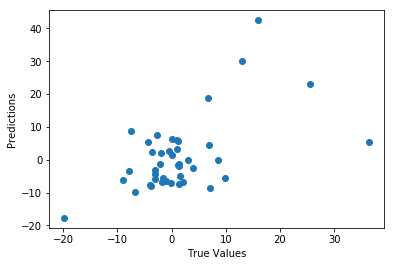

In [326]:
## The line / model
plt.scatter(Y_test, y_pred_lm)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')


# import matplotlib.pyplot as plt
# y_pred_lm_4plt = pd.DataFrame(y_pred_lm.tolist())
# # df['Future_change_low_income_pop'] = pd.DataFrame(y_pred_lm)
# y_pred_lm_4plt.columns = ['Future_change_low_income_pop']

# Data_list=['Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data'\
#      ,'Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data']
# Coparison=['True','Predicated']
# pos = np.arange(len(Data_list))
# bar_width = 0.5
# PredictoinValues=y_pred_lm_4plt['Future_change_low_income_pop'] #[60,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,100,100]
# TestValues=Y_test['Future_change_low_income_pop'] #[30,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,20,33]

# plt.bar(pos,PredictoinValues,bar_width,color='blue',edgecolor='black')
# plt.bar(pos+bar_width,TestValues,bar_width,color='pink',edgecolor='black')
# plt.xticks(pos, Data_list)
# plt.xlabel('Tested Data', fontsize=12)
# plt.ylabel('Low income population change', fontsize=12)
# plt.title('Comaprison between true and predicated value',fontsize=14)
# plt.legend(Coparison,loc=2)
# plt.show()

# print(y_pred)
# print(Y_test)

RMS =     Future_change_low_income_pop
173                      2.531198
112                      0.881204
270                      0.364619
102                      3.856807
110                      4.807781
11                       0.093924
126                      1.335816
33                       1.608402
89                       0.329144
230                     81.265881
184                      2.689803
177                      1.131750
267                      2.431498
1                        2.074108
61                       1.583621
271                      2.218281
54                       5.445575
140                      1.783537
63                       0.294406
159                      1.653154
25                       6.479684
131                      0.453900
257                      0.104706
106                      2.226775
160                      5.327918
148                      0.851164
15                       2.543379
254                      3.610622
139      

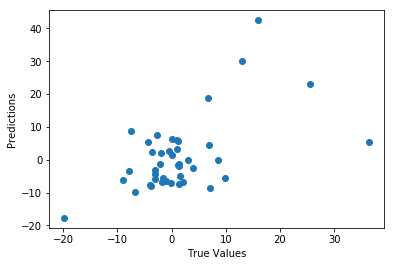

In [327]:
y_pred_lm= lmodel.predict(X_test)
# y_pred_LR= LR_model.predict(X_test)
# y_pred_lm= pd.DataFrame(y_pred_lm).asarray()


rms_LM = np.sqrt(mean_squared_error(Y_test, y_pred_lm))

Error_precentage = np.abs(Y_test - y_pred_lm)/np.abs(Y_test)
#print(Y_test , y_pred_lm)
print("RMS ="+str(Error_precentage))
print("Error Percentage:"+str(np.mean(Error_precentage)))
print(100-np.mean(Error_precentage))

# rms_LR = np.sqrt(mean_squared_error(Y_test, y_pred_LR))

print("RMS ="+str(rms_LM))
# print("RMS ="+str(rms_LR))


## The line / model
plt.scatter(Y_test, y_pred_lm)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')


# import matplotlib.pyplot as plt
# y_pred_lm_4plt = pd.DataFrame(y_pred_lm.tolist())
# # df['Future_change_low_income_pop'] = pd.DataFrame(y_pred_lm)
# y_pred_lm_4plt.columns = ['Future_change_low_income_pop']

# Data_list=['Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data'\
#      ,'Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data']
# Coparison=['True','Predicated']
# pos = np.arange(len(Data_list))
# bar_width = 0.5
# PredictoinValues=y_pred_lm_4plt['Future_change_low_income_pop'] #[60,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,100,100]
# TestValues=Y_test['Future_change_low_income_pop'] #[30,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,20,33]

# plt.bar(pos,PredictoinValues,bar_width,color='blue',edgecolor='black')
# plt.bar(pos+bar_width,TestValues,bar_width,color='pink',edgecolor='black')
# plt.xticks(pos, Data_list)
# plt.xlabel('Tested Data', fontsize=12)
# plt.ylabel('Low income population change', fontsize=12)
# plt.title('Comaprison between true and predicated value',fontsize=14)
# plt.legend(Coparison,loc=2)
# plt.show()

# print(y_pred)
# print(Y_test)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

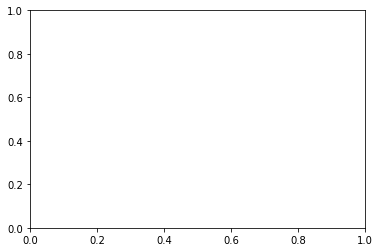

In [328]:
Y_test['Future_change_low_income_pop']
plt.bar(pos,Y_test['Future_change_low_income_pop'])
plt.show()

df = pd.DataFrame(y_pred_lm.tolist())
# df['Future_change_low_income_pop'] = pd.DataFrame(y_pred_lm)
df.columns = ['Future_change_low_income_pop']
plt.bar(pos,df['Future_change_low_income_pop'])

In [ ]:
y_pred_lm

In [ ]:
loaded_model = pickle.load(open('finalized_lmodel.sav', 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

os.chdir('/Users/hadi/Documents/Professional_development/DS/INSIGHT/Project/Data/Data_pro')
Test_2016=pd.read_csv('Data_All_sorted_alpha_MVP_2016_V6.csv')

#print(pd.isna(Test_2016))

Test_2016.index = Test_2016.Neighbourhood
Y_2016 = pd.DataFrame(Test_2016['Future_change_low_income_pop'])
X_2016 = pd.DataFrame(Test_2016[['Home price','Change in housing pricing','Low income population',\
                           'Change in low income pop','Total Area','Total Population',\
                           'Pop  25 - 34 years','Recent Immigrants','TTC Stops','Health Providers','Businesses',\
                           'Social Housing Units','Rent Bank Applicants']])
# pd.isna(X_2016)


Y_2016 = loaded_model.predict(X_2016)

#Y_2016.index = Y_2016.Neighbourhood
neighb_name='Agincourt-North'

for i in range(0,137):
    if Test_2016.index[i]==neighb_name:
        indexnumber=i

print(Test_2016.index)
print(indexnumber)
print(Y_2016)
print(Y_2016[indexnumber])

#print(df.Y_2016[i])

from matplotlib import pyplot as plt
Goodlm=lm
y_pred = Goodlm.predict(X_test)
rms = np.sqrt(mean_squared_error(Y_test, y_pred))
# print(rms)
# print(y_pred)
# print(Y_test)

Error_precentage = np.abs(Y_test - y_pred_lm)/np.abs(y_pred_lm)
print(Error_precentage)


## The line / model
plt.scatter(Y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')


In [ ]:
import copy 
Goodlm=copy.deepcopy(lm)
Good_X_train_L_V2=copy.deepcopy(X_train) 
Good_X_test_L_V2=copy.deepcopy(X_test)
Good_Y_train_L_V2=copy.deepcopy(Y_train)  
Good_Y_test_L_V2=copy.deepcopy(Y_test)

In [3]:
import os
os.chdir('/Users/hadi/Documents/Professional development/DS/INSIGHT/Project/Data/Data_pro')
raw_data=pd.read_csv('Data_All_sorted_alpha_MVP_V5.csv')
raw_data.index = raw_data.Neighbourhood
Y = pd.DataFrame(raw_data['Future_change_low_income_pop'])
Y=Y*100
print (Y)
X = pd.DataFrame(raw_data[['Home price','Change in housing pricing','Low income population',\
                           'Change in low income pop','Total Area','Total Population',\
                           'Pop  25 - 34 years','Recent Immigrants','TTC Stops','Health Providers','Businesses',\
                           'Social Housing Units','Rent Bank Applicants']])

import altair as alt
import pandas as pd

source = raw_data.Future_change_low_income_pop
threshold = pd.DataFrame([{"threshold": 10}])

bars = alt.Chart(source).mark_bar().encode(x="year:O",y="wheat:Q")

highlight = alt.Chart(source).mark_bar(color="#e45755").encode(x='year:O',y='baseline:Q', y2='wheat:Q').transform_filter(alt.datum.wheat > 10).transform_calculate("baseline", "10")

rule = alt.Chart(threshold).mark_rule().encode(y='threshold:Q')

(bars + highlight + rule).properties(width=600)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hadi/Documents/Professional development/DS/INSIGHT/Project/Data/Data_pro'

In [4]:
raw_data

NameError: name 'raw_data' is not defined

In [7]:
import researchpy as rp
corr_type, corr_matrix, corr_ps = rp.corr_case(raw_data[['Future_change_low_income_pop','Home price','Change in housing pricing','Low income population',\
                           'Change in low income pop','Total Area','Total Population',\
                           'Pop  25 - 34 years','Recent Immigrants','TTC Stops','Health Providers','Businesses',\
                           'Social Housing Units','Rent Bank Applicants']])

In [8]:
corr_matrix

,Future_change_low_income_pop,Home price,Change in housing pricing,Low income population,Change in low income pop,Total Area,Total Population,Pop 25 - 34 years,Recent Immigrants,TTC Stops,Health Providers,Businesses,Social Housing Units,Rent Bank Applicants
Future_change_low_income_pop,1,0.1725,0.1164,0.1228,0.5879,0.0662,0.134,0.4473,0.0434,0.1223,0.18,0.4364,0.2986,0.0032
Home price,0.1725,1,0.0725,-0.1717,0.1353,-0.185,-0.168,0.043,-0.2959,-0.1408,0.2457,0.1314,-0.1244,-0.4282
Change in housing pricing,0.1164,0.0725,1,-0.1591,0.0662,-0.1395,-0.1583,0.0322,-0.0841,-0.1083,0.1433,0.1935,0.0044,-0.1148
Low income population,0.1228,-0.1717,-0.1591,1,0.2294,0.5999,0.9909,0.7656,0.755,0.6609,0.4443,0.4053,0.3482,0.4721
Change in low income pop,0.5879,0.1353,0.0662,0.2294,1,0.1902,0.2327,0.4225,0.1281,0.1637,0.1901,0.319,0.1729,-0.0224
Total Area,0.0662,-0.185,-0.1395,0.5999,0.1902,1,0.6006,0.3043,0.3187,0.8035,0.2139,0.3607,0.0173,0.3354
Total Population,0.134,-0.168,-0.1583,0.9909,0.2327,0.6006,1,0.7828,0.7392,0.6658,0.4472,0.4165,0.3576,0.4713
Pop 25 - 34 years,0.4473,0.043,0.0322,0.7656,0.4225,0.3043,0.7828,1,0.5506,0.424,0.4961,0.609,0.5311,0.3037
Recent Immigrants,0.0434,-0.2959,-0.0841,0.755,0.1281,0.3187,0.7392,0.5506,1,0.3741,0.3232,0.2362,0.2656,0.4778
TTC Stops,0.1223,-0.1408,-0.1083,0.6609,0.1637,0.8035,0.6658,0.424,0.3741,1,0.4367,0.6068,0.1326,0.3839


In [48]:
results

array([-136.60759983, -250.50924602, -269.47829462])

In [28]:
print(Y_train)

[-1.41575300e-01 -1.11724110e+00 -5.88290400e+00  2.30507430e+00
  9.29713700e-01 -1.13740470e+00  1.53741040e+00  2.69395930e+00
 -1.16480152e+01 -7.52061200e+00 -4.39272880e+00  5.46742860e+00
  7.64148000e-02 -5.36744200e-01  8.68240800e-01  9.76593570e+00
 -3.62465210e+00  5.82873240e+00 -7.32211410e+00  8.62696450e+00
 -4.71806600e+00  4.43914480e+00  4.60490400e-01  3.27586520e+00
 -8.67973600e-01 -6.90450040e+00  6.50963430e+00 -4.82923000e-01
  7.64603660e+00  4.19024750e+00 -1.44804290e+00  2.49078387e+01
  1.77959780e+00 -4.50760373e+01  4.01839600e-01  4.46357660e+00
 -3.80109930e+00  4.42917400e-01  1.41568271e+01 -1.99906830e+00
  3.79251380e+00 -3.08038800e-01  1.59974404e+01 -4.92344790e+00
  3.78765261e+01  9.93351380e+00  3.63627956e+01 -3.06928600e+00
  2.93404310e+00 -2.93863430e+00  3.35834060e+00  7.35381080e+00
 -1.62994769e+01  3.76536000e-02  3.33202451e+01 -4.08175820e+00
  1.16344800e+00  8.26346400e-01 -7.91003120e+00 -2.65995180e+00
 -9.11549000e-02  2.07253